# Selección de features y modelización

## Importación de librerías

In [30]:
# Librerías para visualización de datos
import matplotlib.pyplot as plt
import seaborn as sns

# Librerías para manipulación y análisis de datos
import numpy as np
import pandas as pd


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline


from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer, recall_score, auc

from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve


from toolbox_DS import *
from toolbox_ML import *


import warnings
warnings.filterwarnings(action="ignore", message=r'.*Use subset.*of np.ndarray is not recommended')


## Carga de datos

Train

In [31]:
train_set = pd.read_csv('./data/train_set.csv')
train_set

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Response,income_missing,age,customes_seniority,Household_members,Total_amount,Total_purchase,Median_amount_purchase,Total_cmp,Total_%_cmp
0,5675,1960,PhD,Divorced,50611.0,0,1,2012-10-04,98,459,...,0,0,55,3,2.0,493,22,22.409091,1,0.2
1,5543,1966,Graduation,Together,57811.0,0,1,2013-06-24,49,545,...,0,0,49,2,3.0,802,25,32.080000,1,0.2
2,3011,1965,Graduation,Married,69139.0,0,1,2014-01-27,23,86,...,0,0,50,1,3.0,227,11,20.636364,0,0.0
3,535,1987,Graduation,Divorced,81361.0,0,0,2014-02-25,18,163,...,0,0,28,1,1.0,778,27,28.814815,0,0.0
4,10755,1976,2n Cycle,Married,23718.0,1,0,2013-09-02,76,6,...,0,0,39,2,3.0,81,9,9.000000,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1785,5320,1973,Master,Divorced,44051.0,1,1,2013-01-29,20,79,...,1,0,42,2,3.0,171,12,14.250000,0,0.0
1786,2894,1985,Graduation,Single,72903.0,0,0,2013-10-29,74,1067,...,1,0,30,2,1.0,2013,21,95.857143,3,0.6
1787,1726,1970,Graduation,Single,22585.0,0,0,2013-03-18,23,3,...,1,0,45,2,1.0,81,5,16.200000,1,0.2
1788,6905,1994,Graduation,Together,80685.0,0,0,2012-08-22,55,241,...,0,0,21,3,2.0,1004,21,47.809524,0,0.0


Test

In [32]:
test_set = pd.read_csv('./data/test_set.csv')
test_set.head(5)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,Complain,Response,age,customes_seniority,Household_members,Total_amount,Total_purchase,Median_amount_purchase,Total_cmp,Total_%_cmp
0,2853,1980,Graduation,Single,51766.0,1,0,2014-03-11,74,60,...,0,0,35,1,2.0,275,12,22.916667,0,0.0
1,10492,1959,Graduation,Together,38285.0,2,1,2014-06-24,96,2,...,0,0,56,1,5.0,10,4,2.500000,0,0.0
2,8939,1959,Graduation,Divorced,61250.0,0,1,2012-12-16,49,382,...,0,0,56,3,2.0,730,25,29.200000,0,0.0
3,6274,1948,Master,Married,83790.0,0,0,2013-11-15,81,1076,...,0,0,67,2,2.0,1615,25,64.600000,2,0.4
4,10232,1963,PhD,Divorced,48799.0,0,1,2013-11-05,9,174,...,0,0,52,2,2.0,331,15,22.066667,0,0.0


Imputo los cambios que vengo aplicando al dataset.    
Train

In [33]:
# Cambio el índice
train_set.set_index('ID', inplace=True)

# Cambio tipo a datetime
train_set['Dt_Customer'] = pd.to_datetime(train_set['Dt_Customer'])

# Cambiar tipo a categóricas
cols_to_category = ['Education', 'Marital_Status']
train_set[cols_to_category] = train_set[cols_to_category].astype('category')

# Elimino columna 'income_missing'
train_set = train_set.drop(columns=['income_missing', 'Year_Birth','Total_%_cmp','Dt_Customer','Median_amount_purchase'])

# Elimino el outlier de Income
train_set = train_set.loc[train_set['Income'] !=666666]

Y también al test

In [34]:
# Cambio el índice
test_set.set_index('ID', inplace=True)

# Cambio tipo a datetime
test_set['Dt_Customer'] = pd.to_datetime(test_set['Dt_Customer'])

# Cambiar tipo a categóricas
cols_to_category = ['Education', 'Marital_Status']
test_set[cols_to_category] = test_set[cols_to_category].astype('category')

# Elimino columna 'income_missing'
test_set = test_set.drop(columns=['Year_Birth','Total_%_cmp','Dt_Customer','Median_amount_purchase'])

# Elimino el outlier de Income
test_set = test_set.loc[test_set['Income'] !=666666]

## Transformación de variables

In [35]:
X_train = train_set.drop(columns='Response')
y_train = train_set['Response']

X_test = test_set.drop(columns='Response')
y_test = test_set['Response']

In [36]:
features_num = X_train.select_dtypes(['int','float']).columns
features_cat = X_train.select_dtypes(['object', 'category']).columns
print('features_num', features_num)
print('features_cat', features_cat)

features_num Index(['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'age', 'customes_seniority',
       'Household_members', 'Total_amount', 'Total_purchase', 'Total_cmp'],
      dtype='object')
features_cat Index(['Education', 'Marital_Status'], dtype='object')


In [37]:
# Definimos el OrdinalEncoder con el mapeo de 'education_ode'
ordinal_encoder = OrdinalEncoder(categories=[['Basic', '2n Cycle', 'Graduation', 'Master', 'PhD']])

categorical_features_onehot = ['Marital_Status']
categorical_features_ordinal = ['Education']
numerical_features = features_num

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat_onehot', OneHotEncoder(), categorical_features_onehot),
        ('cat_ordinal', Pipeline([
            ('ordinal', ordinal_encoder),
            ('scaler', MinMaxScaler())
        ]), categorical_features_ordinal)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocesor',preprocessor),
    ('algoritmo', RandomForestClassifier())
])

pipeline.fit(X_train,y_train)

X_train_transform = pipeline.named_steps['preprocesor'].transform(X_train)


In [38]:
features_transformed = pipeline.named_steps['preprocesor'].get_feature_names_out()
features_transformed

array(['num__Income', 'num__Kidhome', 'num__Teenhome', 'num__Recency',
       'num__MntWines', 'num__MntFruits', 'num__MntMeatProducts',
       'num__MntFishProducts', 'num__MntSweetProducts',
       'num__MntGoldProds', 'num__NumDealsPurchases',
       'num__NumWebPurchases', 'num__NumCatalogPurchases',
       'num__NumStorePurchases', 'num__NumWebVisitsMonth',
       'num__AcceptedCmp3', 'num__AcceptedCmp4', 'num__AcceptedCmp5',
       'num__AcceptedCmp1', 'num__AcceptedCmp2', 'num__Complain',
       'num__age', 'num__customes_seniority', 'num__Household_members',
       'num__Total_amount', 'num__Total_purchase', 'num__Total_cmp',
       'cat_onehot__Marital_Status_Alone',
       'cat_onehot__Marital_Status_Divorced',
       'cat_onehot__Marital_Status_Married',
       'cat_onehot__Marital_Status_Others',
       'cat_onehot__Marital_Status_Single',
       'cat_onehot__Marital_Status_Together',
       'cat_onehot__Marital_Status_Widow', 'cat_ordinal__Education'],
      dtype=object)

In [39]:
X_train_transform_df = pd.DataFrame(X_train_transform, columns=(features_transformed))
X_train_transform_df

,num__Income,num__Kidhome,num__Teenhome,num__Recency,num__MntWines,num__MntFruits,num__MntMeatProducts,num__MntFishProducts,num__MntSweetProducts,num__MntGoldProds,...,num__Total_purchase,num__Total_cmp,cat_onehot__Marital_Status_Alone,cat_onehot__Marital_Status_Divorced,cat_onehot__Marital_Status_Married,cat_onehot__Marital_Status_Others,cat_onehot__Marital_Status_Single,cat_onehot__Marital_Status_Together,cat_onehot__Marital_Status_Widow,cat_ordinal__Education
0,50611.0,0.0,1.0,98.0,459.0,0.0,24.0,6.0,0.0,4.0,...,22.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.00
1,57811.0,0.0,1.0,49.0,545.0,7.0,114.0,37.0,21.0,78.0,...,25.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50
2,69139.0,0.0,1.0,23.0,86.0,12.0,75.0,33.0,15.0,6.0,...,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.50
3,81361.0,0.0,0.0,18.0,163.0,23.0,424.0,27.0,65.0,76.0,...,27.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.50
4,23718.0,1.0,0.0,76.0,6.0,3.0,14.0,15.0,7.0,36.0,...,9.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1784,44051.0,1.0,1.0,20.0,79.0,7.0,58.0,6.0,3.0,18.0,...,12.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.75
1785,72903.0,0.0,0.0,74.0,1067.0,138.0,750.0,0.0,19.0,39.0,...,21.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.50
1786,22585.0,0.0,0.0,23.0,3.0,9.0,15.0,13.0,2.0,39.0,...,5.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.50
1787,80685.0,0.0,0.0,55.0,241.0,45.0,604.0,34.0,26.0,54.0,...,21.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.50


## Features Selection

El problema de utlizar la fórmula es que se pierde explicabilidady en este contexto es muy importante.    
Voy a hacer algún modelo 'a mano'.

#### Selección de features numéricas mediante SelectKBeest y Anova

In [40]:
selector =SelectKBest(f_regression, k = 20)

x_data_kbest = selector.fit_transform(X_train_transform_df, y_train)

features_kbest= selector.get_feature_names_out()
features_kbest

array(['num__Income', 'num__Teenhome', 'num__Recency', 'num__MntWines',
       'num__MntFruits', 'num__MntMeatProducts', 'num__MntFishProducts',
       'num__MntGoldProds', 'num__NumWebPurchases',
       'num__NumCatalogPurchases', 'num__AcceptedCmp3',
       'num__AcceptedCmp4', 'num__AcceptedCmp5', 'num__AcceptedCmp1',
       'num__AcceptedCmp2', 'num__customes_seniority',
       'num__Household_members', 'num__Total_amount',
       'num__Total_purchase', 'num__Total_cmp'], dtype=object)

#### Selección usando modelo RFE

In [41]:
# Instnacio modelo de clasificación
rf_RFE = RandomForestRegressor(max_depth=5,random_state=42)

# Sobre el modelo instancio el rfe
rfe = RFE(
    estimator=rf_RFE,
    n_features_to_select=20,
    step=1, 
    )

# Entreno el modelo rfe
rfe.fit(X_train_transform_df,y_train)
print(rfe.ranking_)
pd.DataFrame(rfe.ranking_,columns=['ranking'], index=features_transformed).sort_values('ranking')
features_RFE= rfe.get_feature_names_out()
features_RFE

[ 1 11  6  1  1  1  1  1  1  1  1  2  1  1  1  1  3 12  9 13 14  1  1  1
  1  1  1 15  7  4 16  5  8 10  1]


array(['num__Income', 'num__Recency', 'num__MntWines', 'num__MntFruits',
       'num__MntMeatProducts', 'num__MntFishProducts',
       'num__MntSweetProducts', 'num__MntGoldProds',
       'num__NumDealsPurchases', 'num__NumCatalogPurchases',
       'num__NumStorePurchases', 'num__NumWebVisitsMonth',
       'num__AcceptedCmp3', 'num__age', 'num__customes_seniority',
       'num__Household_members', 'num__Total_amount',
       'num__Total_purchase', 'num__Total_cmp', 'cat_ordinal__Education'],
      dtype=object)

#### Selección por SFS

In [42]:
# Instancio modelo clasificación
rf_sfs = RandomForestRegressor(max_depth=5,random_state=42)
# Instancio el modelo de la features selection
sfs_fordward = SequentialFeatureSelector(
    rf_sfs,
    n_features_to_select=20,
    cv = 3,
    )

# Entreno el modelo de features_selection
sfs_fordward.fit(X_train_transform_df,y_train)
features_SFS= sfs_fordward.get_feature_names_out()

### Hard Voting

In [43]:
listas_features = [features_kbest,features_RFE,features_SFS]
dicc_hard_voting = {}

for col in features_transformed:
    count = 0
    for lista in listas_features:
        if col in lista:
            count +=1
    dicc_hard_voting[col]=count
pprint(dicc_hard_voting)

{'cat_onehot__Marital_Status_Alone': 1,
 'cat_onehot__Marital_Status_Divorced': 0,
 'cat_onehot__Marital_Status_Married': 0,
 'cat_onehot__Marital_Status_Others': 1,
 'cat_onehot__Marital_Status_Single': 0,
 'cat_onehot__Marital_Status_Together': 1,
 'cat_onehot__Marital_Status_Widow': 1,
 'cat_ordinal__Education': 2,
 'num__AcceptedCmp1': 1,
 'num__AcceptedCmp2': 2,
 'num__AcceptedCmp3': 3,
 'num__AcceptedCmp4': 2,
 'num__AcceptedCmp5': 1,
 'num__Complain': 1,
 'num__Household_members': 3,
 'num__Income': 2,
 'num__Kidhome': 1,
 'num__MntFishProducts': 2,
 'num__MntFruits': 2,
 'num__MntGoldProds': 3,
 'num__MntMeatProducts': 3,
 'num__MntSweetProducts': 2,
 'num__MntWines': 2,
 'num__NumCatalogPurchases': 2,
 'num__NumDealsPurchases': 1,
 'num__NumStorePurchases': 2,
 'num__NumWebPurchases': 1,
 'num__NumWebVisitsMonth': 2,
 'num__Recency': 3,
 'num__Teenhome': 2,
 'num__Total_amount': 2,
 'num__Total_cmp': 3,
 'num__Total_purchase': 2,
 'num__age': 1,
 'num__customes_seniority': 3}


In [44]:
features_hard_voting = []

for i,j in dicc_hard_voting.items():
    if j == 2 or j == 3:
        features_hard_voting.append(i)
features_hard_voting

['num__Income',
 'num__Teenhome',
 'num__Recency',
 'num__MntWines',
 'num__MntFruits',
 'num__MntMeatProducts',
 'num__MntFishProducts',
 'num__MntSweetProducts',
 'num__MntGoldProds',
 'num__NumCatalogPurchases',
 'num__NumStorePurchases',
 'num__NumWebVisitsMonth',
 'num__AcceptedCmp3',
 'num__AcceptedCmp4',
 'num__AcceptedCmp2',
 'num__customes_seniority',
 'num__Household_members',
 'num__Total_amount',
 'num__Total_purchase',
 'num__Total_cmp',
 'cat_ordinal__Education']

In [45]:
# Instancio modelos
ratio = float(np.sum(y_train == 0)) / np.sum(y_train == 1)
xgb = XGBClassifier(max_depth=10, scale_pos_weight=ratio,random_state = 42)
rf = RandomForestClassifier(max_depth=10, random_state=42, class_weight='balanced')
lgb = LGBMClassifier(max_depth=10, is_unbalance = True, objective= 'binary', random_state = 42, verbose = -1)

In [46]:
modelos = (xgb,rf,lgb)
features_list = (features_kbest,features_RFE,features_SFS,features_hard_voting)
model_name = ('XGBoost', 'RandomForest', 'LightGBM')
features_name = ('features_kbest','features_RFE','features_SFS','features_hard_voting')

best_result = {}

for model, name in zip(modelos, model_name):
    for i,lista in enumerate(features_list):
        score = cross_val_score(model, X_train_transform_df[lista], y_train, cv=3, scoring=make_scorer(recall_score, pos_label=True))
        best_score = np.mean(score)
        best_result['name'] = (lista,best_score)

        print(f'Para el modelo {name} con la lista {features_name[i]}: {best_score:.2f}')

Para el modelo XGBoost con la lista features_kbest: 0.47
Para el modelo XGBoost con la lista features_RFE: 0.49
Para el modelo XGBoost con la lista features_SFS: 0.56
Para el modelo XGBoost con la lista features_hard_voting: 0.51
Para el modelo RandomForest con la lista features_kbest: 0.33
Para el modelo RandomForest con la lista features_RFE: 0.34
Para el modelo RandomForest con la lista features_SFS: 0.42
Para el modelo RandomForest con la lista features_hard_voting: 0.32
Para el modelo LightGBM con la lista features_kbest: 0.51
Para el modelo LightGBM con la lista features_RFE: 0.52
Para el modelo LightGBM con la lista features_SFS: 0.58
Para el modelo LightGBM con la lista features_hard_voting: 0.53


Con una lista máx. de 20 variables, el mejor algoritmo sería el LightGBM con la lista features_SFS con 0.61 de recall de la clase positiva

## Modelización

### Prueba de modelos con todas las variables

In [47]:
pipe = Pipeline(steps=[
    ('preprocesor', preprocessor),
    ('algoritmo', RandomForestClassifier())
])


# Definir el grid de hiperparámetros
grid = [
    {'algoritmo': [RandomForestClassifier()],
     'algoritmo__max_depth': [5, 10, 15],
     'algoritmo__n_estimators': [50, 100, 200],
     'algoritmo__class_weight':['balanced']},
   
    {'algoritmo': [XGBClassifier()],
     'algoritmo__learning_rate': [0.1, 0.3, 0.5],
     'algoritmo__n_estimators': [100, 500, 1000],
     'algoritmo__scale_pos_weight':[ratio]},
    
    {'algoritmo': [LGBMClassifier()],
     'algoritmo__learnin_rate': [0.1, 0.3, 0.5],
     'algoritmo__n_estimators': [100, 500, 1000],
     'algoritmo__is_unbalance' : [True],
     'algoritmo__objective': ['binary']}
]


# Realizar GridSearchCV con el scorer personalizado
grid_search = GridSearchCV(pipe, 
                           grid, 
                           cv=5, 
                           scoring=make_scorer(recall_score, pos_label=True), 
                           n_jobs=-1)


grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y parámetros
best_model = grid_search.best_estimator_
print("Mejor modelo y parámetros:", grid_search.best_params_)

AttributeError: 'ColumnTransformer' object has no attribute 'force_int_remainder_cols'

In [ ]:
grid_search.best_score_

0.6617749825296995

In [ ]:
df_cv_results = pd.DataFrame(grid_search.cv_results_)
df_cv_results[['param_algoritmo','mean_test_score','std_test_score','rank_test_score']].sort_values('rank_test_score')

,param_algoritmo,mean_test_score,std_test_score,rank_test_score
0,RandomForestClassifier(),0.661775,0.031112,1
1,RandomForestClassifier(),0.661775,0.035246,1
2,RandomForestClassifier(),0.650454,0.049566,3
9,"XGBClassifier(base_score=None, booster=None, c...",0.590915,0.040551,4
24,LGBMClassifier(),0.565059,0.060294,5
21,LGBMClassifier(),0.565059,0.060294,5
18,LGBMClassifier(),0.565059,0.060294,5
15,"XGBClassifier(base_score=None, booster=None, c...",0.561286,0.019818,8
10,"XGBClassifier(base_score=None, booster=None, c...",0.561146,0.053510,9
17,"XGBClassifier(base_score=None, booster=None, c...",0.557512,0.023585,10


Haciendo un pipeline con todas las variables, el mejor sería un RandomForest con una recall de la clase positiva de 0.66

## Ajuste hiperparámetros

### RandomForest

In [ ]:
pipe = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('algoritmo', RandomForestClassifier())
])

param = {
    'algoritmo__n_estimators': [400,450,500],
    'algoritmo__max_depth': [5, 6,7],
    'algoritmo__min_samples_split': [3,4,5],
    'algoritmo__min_samples_leaf': [8,10,12],
    'algoritmo__class_weight': ['balanced']
}

grid_rf = GridSearchCV(pipe, 
                       param_grid=param, 
                       cv=5, 
                       scoring=make_scorer(recall_score, pos_label=True), 
                       n_jobs=-1)

grid_rf.fit(X_train, y_train)

# Obtener el mejor modelo y parámetros
best_model_rf = grid_rf.best_estimator_
best_params_rf = grid_rf.best_params_
print("Mejor modelo y parámetros:", best_params_rf)

# Imprimir el mejor resultado del recall para la clase positiva
best_recall_rf = grid_rf.best_score_
print("Mejor resultado del recall para la clase positiva:", best_recall_rf)


Mejor modelo y parámetros: {'algoritmo__class_weight': 'balanced', 'algoritmo__max_depth': 6, 'algoritmo__min_samples_leaf': 12, 'algoritmo__min_samples_split': 3, 'algoritmo__n_estimators': 400}
Mejor resultado del recall para la clase positiva: 0.7138364779874213


In [ ]:
# Acceder al modelo dentro del Pipeline
random_forest_model = best_model_rf.named_steps['algoritmo']

# Obtener las importancias de las características
feature_importances = random_forest_model.feature_importances_

if 'preprocesador' in best_model_rf.named_steps:
    preprocessor = best_model_rf.named_steps['preprocesador']
    feature_names = preprocessor.get_feature_names_out()

    importances_series = pd.Series(feature_importances, index=feature_names)
    print(importances_series.sort_values(ascending=False))

num__Total_cmp                         0.152178
num__Recency                           0.083636
num__Total_amount                      0.074611
num__MntGoldProds                      0.064590
num__MntMeatProducts                   0.058411
num__Household_members                 0.050621
num__AcceptedCmp5                      0.045891
num__Income                            0.045819
num__NumCatalogPurchases               0.045677
num__MntWines                          0.045527
num__AcceptedCmp3                      0.042503
num__customes_seniority                0.035559
num__NumWebVisitsMonth                 0.033680
num__AcceptedCmp1                      0.028701
num__NumStorePurchases                 0.025045
num__MntSweetProducts                  0.021291
num__NumWebPurchases                   0.018903
num__Total_purchase                    0.018277
num__MntFruits                         0.017832
num__Teenhome                          0.016212
num__NumDealsPurchases                 0

### LigthGBM

In [ ]:
pipe = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('algoritmo', LGBMClassifier())
])

param = {
    'algoritmo__max_depth': [4,5, 6],
    'algoritmo__min_child_samples': [2,4,8],
    'algoritmo__min_child_weight': [4, 8,10],
    'algoritmo__learning_rate': [0.09, 0.1, 0.2],
    'algoritmo__n_estimators': [100, 200, 300],
    'algoritmo__is_unbalance' : [True],
    'algoritmo__objective': ['binary'],
}

grid_lgb = GridSearchCV(pipe, 
                       param_grid=param, 
                       cv=5, 
                       scoring=make_scorer(recall_score, pos_label=True), 
                       n_jobs=-1,
                       verbose= 1)

grid_lgb.fit(X_train, y_train)

# Obtener el mejor modelo y parámetros
best_model_lgb = grid_lgb.best_estimator_
best_params_lgb = grid_lgb.best_params_
print("Mejor modelo y parámetros:", best_params_lgb)

# Imprimir el mejor resultado del recall para la clase positiva
best_recall_lgb = grid_lgb.best_score_
print("Mejor resultado del recall para la clase positiva:", best_recall_lgb)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[LightGBM] [Info] Number of positive: 269, number of negative: 1520
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1853
[LightGBM] [Info] Number of data points in the train set: 1789, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.150363 -> initscore=-1.731754
[LightGBM] [Info] Start training from score -1.731754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightG

In [ ]:
# Acceder al modelo dentro del Pipeline
lgb_model = best_model_lgb.named_steps['algoritmo']

# Obtener las importancias de las características
feature_importances = lgb_model.feature_importances_

if 'preprocesador' in best_model_lgb.named_steps:
    preprocessor = best_model_lgb.named_steps['preprocesador']
    feature_names = preprocessor.get_feature_names_out()

    importances_series = pd.Series(feature_importances, index=feature_names)
    print(importances_series.sort_values(ascending=False))

num__Recency                           145
num__MntMeatProducts                    67
num__MntGoldProds                       62
num__Total_cmp                          58
num__age                                55
num__NumStorePurchases                  54
num__NumWebVisitsMonth                  50
num__MntSweetProducts                   48
num__MntWines                           46
num__Household_members                  44
num__customes_seniority                 44
num__Income                             43
cat_ordinal__Education                  41
num__MntFruits                          31
num__Total_amount                       28
num__MntFishProducts                    24
num__NumCatalogPurchases                24
num__NumWebPurchases                    18
num__Teenhome                           16
num__NumDealsPurchases                  16
num__Total_purchase                     15
cat_onehot__Marital_Status_Married      14
num__AcceptedCmp5                       14
cat_onehot_

### XGBoost

In [ ]:
pipe = Pipeline(steps=[
    ('preprocesador', preprocessor),
    ('algoritmo', XGBClassifier())
])

param = {
    'algoritmo__n_estimators': [300, 400, 450],
    'algoritmo__max_depth': [4, 5, 6],
    'algoritmo__min_child_weight': [6, 8, 10],  # Equivalente a min_samples_leaf en RandomForest
    'algoritmo__gamma': [0, 0.1, 0.2],  # Parámetro para controlar la regularización
    'algoritmo__subsample': [0.7, 0.8, 0.9],  # Porcentaje de muestras usadas para cada árbol
    'algoritmo__colsample_bytree': [0.7, 0.8, 0.9],  # Porcentaje de características usadas para cada árbol
    'algoritmo__scale_pos_weight': [ratio]  # Ponderación de clases para datasets desbalanceados
}


grid_xgb = GridSearchCV(pipe, 
                       param_grid=param, 
                       cv=5, 
                       scoring=make_scorer(recall_score, pos_label=True), 
                       n_jobs=-1,
                       verbose= 3)

grid_xgb.fit(X_train, y_train)

# Obtener el mejor modelo y parámetros
best_model_xgb = grid_xgb.best_estimator_
best_params_xgb = grid_xgb.best_params_
print("Mejor modelo y parámetros:", best_params_xgb)

# Imprimir el mejor resultado del recall para la clase positiva
best_recall_xgb = grid_xgb.best_score_
print("Mejor resultado del recall para la clase positiva:", best_recall_xgb)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Mejor modelo y parámetros: {'algoritmo__colsample_bytree': 0.7, 'algoritmo__gamma': 0.2, 'algoritmo__max_depth': 5, 'algoritmo__min_child_weight': 8, 'algoritmo__n_estimators': 300, 'algoritmo__scale_pos_weight': 5.650557620817844, 'algoritmo__subsample': 0.9}
Mejor resultado del recall para la clase positiva: 0.6431865828092242


In [ ]:
# Acceder al modelo dentro del Pipeline
xgb_model = best_model_xgb.named_steps['algoritmo']

# Obtener las importancias de las características
feature_importances = xgb_model.feature_importances_

if 'preprocesador' in best_model_xgb.named_steps:
    preprocessor = best_model_xgb.named_steps['preprocesador']
    feature_names = preprocessor.get_feature_names_out()

    importances_series = pd.Series(feature_importances, index=feature_names)
    print(importances_series.sort_values(ascending=False))

num__Total_cmp                         0.220172
num__customes_seniority                0.068627
num__Household_members                 0.066530
cat_onehot__Marital_Status_Single      0.038947
num__NumWebVisitsMonth                 0.036663
num__Recency                           0.035630
num__Teenhome                          0.034904
num__AcceptedCmp5                      0.034557
cat_ordinal__Education                 0.032742
num__NumStorePurchases                 0.029930
num__AcceptedCmp3                      0.029727
num__Kidhome                           0.028177
num__AcceptedCmp1                      0.027486
cat_onehot__Marital_Status_Together    0.027044
num__MntMeatProducts                   0.025993
num__NumDealsPurchases                 0.023398
num__MntGoldProds                      0.023347
cat_onehot__Marital_Status_Married     0.022462
num__NumCatalogPurchases               0.021637
num__Income                            0.019905
num__NumWebPurchases                   0

## Evaluación Modelos

#### Classification Report

In [ ]:
# RandomForest
print('##### RandomForest #####')
y_pred_rf = grid_rf.predict(X_test)

print(classification_report(y_test,y_pred_rf))
print()

# LigthGBM
print('##### LightGBM #####')
y_pred_lgb = grid_lgb.predict(X_test)
print(classification_report(y_test,y_pred_lgb))
print()

# XGBoost
print('##### XGBoost #####')
y_pred_xgb = grid_xgb.predict(X_test)
print(classification_report(y_test,y_pred_xgb))
print()



##### RandomForest #####
              precision    recall  f1-score   support

           0       0.91      0.84      0.87       384
           1       0.34      0.50      0.41        64

    accuracy                           0.79       448
   macro avg       0.63      0.67      0.64       448
weighted avg       0.83      0.79      0.81       448


##### LightGBM #####
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       384
           1       0.50      0.62      0.56        64

    accuracy                           0.86       448
   macro avg       0.72      0.76      0.74       448
weighted avg       0.87      0.86      0.86       448


##### XGBoost #####
              precision    recall  f1-score   support

           0       0.92      0.95      0.93       384
           1       0.62      0.52      0.56        64

    accuracy                           0.89       448
   macro avg       0.77      0.73      0.75       448
weight

#### Matrix de confusión

RandomForest

LightGBM

XGBoost



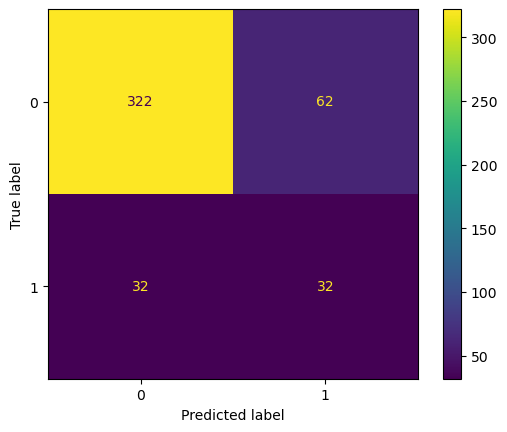

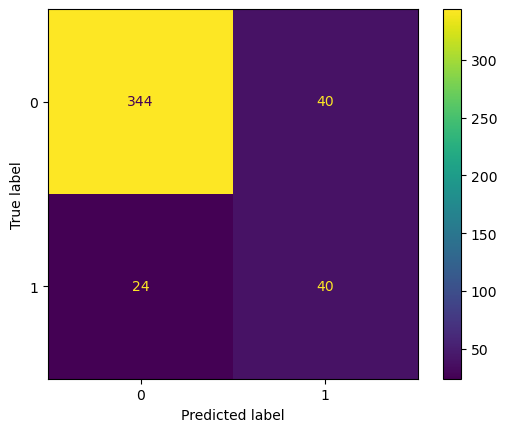

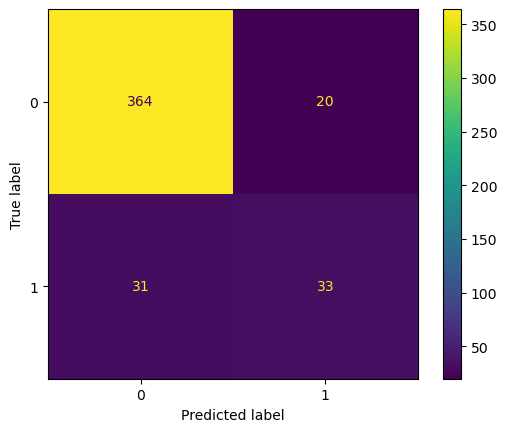

In [ ]:
# RandomForest
print('RandomForest')
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
print()

# LightGBM
print('LightGBM')
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
disp_lgb = ConfusionMatrixDisplay(confusion_matrix=cm_lgb)
disp_lgb.plot()
print()

# XGBoost
print('XGBoost')
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot()
print()